import numpy as np
import matplotlib.pyplot as plt

## Grid Properties

In [2]:
edge = 0.25
area = 0.02

## Reservoir Properties

In [3]:
poro = 0.2
perm = 50.0

## Fluid Properties

In [4]:
visc = 0.01

## Boundary Conditions

In [5]:
pL = 200
pR = 14.7

## Numerical Parameters

In [6]:
ngrid = 4
tstep = 1e-5 # days
nstep = 3

# Matrix Construction

In [7]:
conv = 1.06235016e-14*(24*60*60)/1.45e-7

In [8]:
trans = conv*(perm*area)/(visc*edge)

In [9]:
T = np.zeros((ngrid,ngrid))
S = np.zeros((ngrid,1))
J = np.zeros((ngrid,ngrid))
Q = np.zeros((ngrid,1))

In [10]:
for i in range(ngrid):
  if i==0:
    T[i,i] = trans
    T[i,i+1] = -trans
    J[i,i] = 2*trans
    Q[i,0] = 2*trans*pL
  elif i==ngrid-1:
    T[i,i] = trans
    T[i,i-1] = -trans
    J[i,i] = 2*trans
    Q[i,0] = 2*trans*pR
  else:
    T[i,i] = 2*trans
    T[i,i+1] = -trans
    T[i,i-1] = -trans
  S[i,0] = area*edge*poro

In [11]:
Q

array([[1012.82266289],
       [   0.        ],
       [   0.        ],
       [  74.44246572]])

# Implicit Pressure Calculation

In [12]:
def pressure(dt,P,Pk):
    Act = S/(dt*Pk)
    Act = np.diag(Act.flatten())
    LHS = (T+J+Act)
    RHS = np.matmul(Act,P)+Q
    return np.linalg.solve(LHS,RHS)

# Residual Calculation

In [13]:
def residual(dt,P,Pk):
    Act = S/(dt*Pk)
    Act = np.diag(Act.flatten())
    return -np.matmul((T+J+Act),Pk)+np.matmul(Act,P)+Q

# Picard Method

In [14]:
P0 = np.array([14.7,14.7,14.7,14.7]).reshape((-1,1))

In [15]:
P = P0.copy()

for t in range(nstep):
    Pk = np.copy(P)
    # print(f"TIME STEP - {t+1}")
    for k in range(100):
        F = residual(tstep,P,Pk)
        Pk = pressure(tstep,P,Pk)
        error = np.linalg.norm(F,2)
        # print(f"{k:2}",f"{error:.5e}",Pk.flatten())
        if np.linalg.norm(F,2)<1e-6:
            break
    P = np.copy(Pk)
    print(f"{t:10}",P.flatten())

         0 [146.50848423  75.05643148  35.36304269  18.74622242]
         1 [167.38488971 107.08034753  58.58692986  25.74878913]
         2 [173.05285569 120.45209273  72.23563037  31.48135999]


In [16]:
Ppicard = P

# Jacobian Calculation (Ideal Gas)

In [17]:
def jacobian(dt,P,Pk):
    Act = S.flatten()/(dt*Pk.flatten())
    dia = P.flatten()/Pk.flatten()
    return -(T+J)-np.diag(Act*dia)

In [18]:
jacobian(tstep,P0,P0)

array([[-14.39889106,   2.53205666,  -0.        ,  -0.        ],
       [  2.53205666, -11.8668344 ,   2.53205666,  -0.        ],
       [ -0.        ,   2.53205666, -11.8668344 ,   2.53205666],
       [ -0.        ,  -0.        ,   2.53205666, -14.39889106]])

# Newton's Method

In [19]:
P0 = np.array([14.7,14.7,14.7,14.7]).reshape((-1,1))

In [20]:
P = P0.copy()

for t in range(nstep):
    Pk = np.copy(P)
    # print(f"TIME STEP - {t+1}")
    for k in range(100):
        F = residual(tstep,P,Pk)
        Z = jacobian(tstep,P,Pk)
        Pk += np.linalg.solve(Z,-F)
        error = np.linalg.norm(F,2)
        # print(f"{k:2}",f"{error:.5e}",Pk.flatten())
        if np.linalg.norm(F,2)<1e-6:
            break
    P = np.copy(Pk)
    print(f"{t:10}",P.flatten())

         0 [146.50848426  75.05643156  35.36304276  18.74622244]
         1 [167.38488973 107.08034759  58.58692993  25.74878916]
         2 [173.0528557  120.45209276  72.23563041  31.48136001]


In [21]:
Pnewton = P

# Plotting

In [24]:
xcenter = [edge*i+edge/2 for i in range(ngrid)]

In [25]:
xcenter

[0.125, 0.375, 0.625, 0.875]

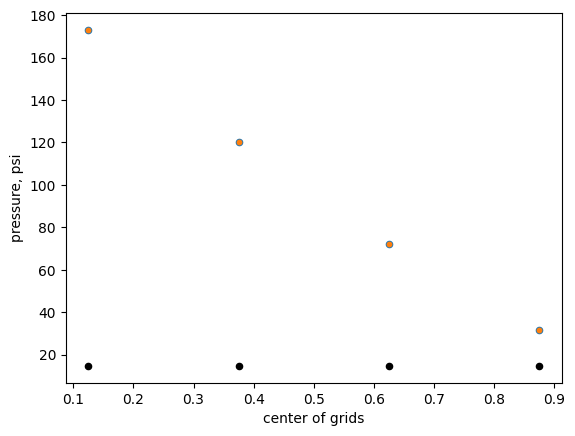

In [31]:
plt.scatter(xcenter,P0,c='k',s=20)
plt.scatter(xcenter,Ppicard,s=20)
plt.scatter(xcenter,Pnewton,s=10)

plt.ylabel("pressure, psi")
plt.xlabel("center of grids")

plt.show()